In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import sys
!conda install --yes --prefix {sys.prefix} xlrd
from dateutil.relativedelta import relativedelta

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
start = '2018-01-01'
end = '2018-02-01'
start_date = datetime.datetime.strptime(start, '%Y-%m-%d').date()
end_date = datetime.datetime.strptime(end, '%Y-%m-%d').date()
final = '2019-01-01'
final_date = datetime.datetime.strptime(final,'%Y-%m-%d').date()

monthly_average = np.zeros((12,1440))
Z=0
while start_date < final_date:
    
    data = pd.read_excel("data/Greenflux Transactions.xlsx", sheet_name="Transaction Data")
    
    #Remove rows where the charge consumed is a NaN value or 0
    data = data[data['ConsumedkWh'].notna()]
    data.drop( data[data['ChargingDuration'] == 0 ].index , inplace=True)

    data['Plugged_In_Start_time'] = pd.to_datetime(data['AdjustedStartTime']).dt.time
    data['Plugged_In_End_time'] = pd.to_datetime(data['AdjustedStopTime']).dt.time

    data['Plugged_In_Start_date'] = pd.to_datetime(data['AdjustedStartTime']).dt.date
    data['Plugged_In_End_date'] = pd.to_datetime(data['AdjustedStopTime']).dt.date
    
    data = data[(data['Plugged_In_Start_date'] > start_date) & (data['Plugged_In_Start_date'] < end_date)]

    dfC = pd.read_csv("data/sspsbpniv.csv")

    MONTH= np.zeros(len(dfC))
    for i in range(len(dfC)):
        MONTH[i] = datetime.datetime.strptime(dfC['Date'].iloc[i], '%d/%m/%Y').date().month

    dfC['Month'] = MONTH
    month = Z+1
    dfc = dfC[dfC['Month'].eq(month)]

    Cost = np.zeros(48)
    for i in range(1,49,1):
        dfc1 = dfc[dfc['HalfHour'].eq(i)]
        Cost[i-1] = np.mean(dfc1['import(VAT)'].iloc[:])
    cost = np.zeros(1440)

    for i in range(len(Cost)):
        cost[(30*(i-1))+30:(30*i)+30] = Cost[i]
 

   
    #Selecting which Trial to look at
    Trial = data[data.WeekdayOrWeekend.eq('Weekday')]

    unique_days = len(pd.unique(Trial['Plugged_In_Start_date']))
    unique_users = len(pd.unique(Trial['ParticipantID']))
    #Convert the times from the excel spreadsheet into minutes
    samp_enter = np.zeros(len(Trial))
    samp_leave = np.zeros(len(Trial))
    for i in range(len(Trial)):
        samp_enter[i] = (Trial['Plugged_In_Start_time'].iloc[i].hour)*60 +Trial['Plugged_In_Start_time'].iloc[i].minute
        samp_leave[i] = (Trial['Plugged_In_End_time'].iloc[i].hour)*60 +Trial['Plugged_In_End_time'].iloc[i].minute

    #For each vehicle randomly pick whether they choose to prioritise time or cost.    
    sample = np.random.binomial(size = len(Trial), n =1, p = 0)

    Priority = ["" for x in range(len(sample))]
    for i in range(len(sample)):
        Priority[i] = 'Time'

    #This is a smart charging algorithm for electric vehicles. It allows the user to chose whether to priorise the speed of 
    #charging or the cost of the charging. It then charges up the vehicle to the level desired by the user, which here is 
    #assumed to be as much as possible, either in the most time-efficient manner or the most cost-efficient manner, by the time
    #the vehicle needs to be unplugged.

    #The algorithm will take as its inputs;the time the vehicle enters/is plugged in, the time the vehicle needs to leave, the
    #prioirty of the user(time or cost), the intial charge of the vehicle and the desired level of charge. Here it is assumed
    #that the user will want to charge up their vehicle as much as possible, which will often be to full capacity, and so the
    #algoirthm below calculates the maximum charge possible and uses this as the desired level.

    #Create a Pandas DataFrame for the first 3 parts algorithm input data. This is the time the vehicle gets plugged in(Enter),
    #assuming the vehicle gets plugges in as soon as it arrives, and the time the vehicle is plugged out(Leave), assuming there
    #is no delay between unplugging the vehicle and leaving.
    data = {'Enter' : samp_enter, 'Leave' : samp_leave, 'Priority': Priority}
    df = pd.DataFrame(data)

    #Initialise verctors
    max_potential_charge = np.zeros(len(df))
    length_stay = np.zeros(len(df))
    charge_if_max_power_for_length_stay = np.zeros(len(df))
    Initial_charge = np.zeros(len(df))

    #Define a round down function in order to deal with Python's rounding errors when storing exact numbers as floats. This
    #becomes important when indexing later on in the actual charging part of the algorithm. 

    def round_down(f, decimal_places=0):
        g = 10 ** decimal_places
        return math.floor(f * g) / g

    #Calculate the maximum charge in kWh that each vehicle can be delivered to each vehicle to based on how long it is plugged 
    #in and state the intial charge. Here it is assumed the inital charge is the same for every vehicle and that each
    #vehicle can be charged up to a max of 25KWh.
    for i in range(len(df)):
        time_in = int(math.ceil(df['Enter'].iloc[i]))
        time_out = int(math.floor(df['Leave'].iloc[i]))
    #Assume every vehicle has an intial charge of 12.5

        Initial_charge[i] = 12.5
        if time_out > time_in:
    #Calculate the duration of the stay
            length_stay[i] = time_out - time_in
    #Calculate the maximum amount of charge that can be delivered to the vehicle
            charge_if_max_power_for_length_stay[i] = (7/60) * length_stay[i]
            if charge_if_max_power_for_length_stay[i] > 25 - Initial_charge[i]:
                max_potential_charge[i] = 25 - Initial_charge[i]
            elif charge_if_max_power_for_length_stay[i] < 25 - Initial_charge[i]:
                max_potential_charge[i] = charge_if_max_power_for_length_stay[i]

        elif time_out < time_in:
            length_stay[i] = (1440 - time_in) + time_out 
            charge_if_max_power_for_length_stay[i] = (7/60) * length_stay[i]
            if charge_if_max_power_for_length_stay[i] > 25 - Initial_charge[i]:
                max_potential_charge[i] = 25 - Initial_charge[i]
            elif charge_if_max_power_for_length_stay[i] < 25 - Initial_charge[i]:
                max_potential_charge[i] = charge_if_max_power_for_length_stay[i]

    df['max_deliverable_charge'] = max_potential_charge
    df['Initial_charge'] = Initial_charge
    energy_desired = np.zeros(len(df))

    #Calculate the total energy that needs to be delivered to each vehicle. Here we assume each user wamts to charge their 
    #vehicle as much as possible
    for e in range(len(df)):   
        if 25 - df['Initial_charge'].iloc[e] > df['max_deliverable_charge'].iloc[e]:
            energy_desired[e] = df['max_deliverable_charge'].iloc[e] + df['Initial_charge'].iloc[e] 
        elif 25 - df['Initial_charge'].iloc[e] <= df['max_deliverable_charge'].iloc[e]:
            energy_desired[e] = 25
    df['energy_desired']= energy_desired
    df['charge_needed'] = df['energy_desired'] - df['Initial_charge']

    #initialise energy and power matrices. Each row has 1440 columns representing a minute of the day each. The power matrix 
    #resprents the power being delivered to each vehicle at each minute of the day. The energy matrix represents the charge 
    #in the vehicles battery. The final_energy vector is used to check that the algorithm works and that the vehicles have been
    #charged up to the desired levels.
    power = np.zeros((len(df),1440))
    energy = np.zeros((len(df),1440))
    final_energy = np.zeros(len(df))

    #Set the maximum charging power to 7kW
    power_max = 7

    #This below is the actual charging part of the algorithm. It first calculates the time the vehicle is plugged in and plugged out
    #so it can use these for indexing. If these times are not in minutes already then they are converted to minutes.     
    for i in range(len(df)):
    #The math.ceil rounds up always and the math.floor rounds down always
        time_in = int(math.ceil(df['Enter'].iloc[i]))
        time_out = int(math.floor(df['Leave'].iloc[i]))
        energy[i,time_in] = df['Initial_charge'].iloc[i]

    #First consider vehicles that enter/leave on the same day
        if time_out > time_in:

    #If the priority is time then the vehicle charges up as quickly as possible
            if df['Priority'].iloc[i] == 'Time':
                t = time_in + 1
                power[i,time_in] = power_max
    #The below while loop, followed by the additional power term is used to make sure that the vehicles charge up to exactly 
    #the charge desired and not slightly above or below this.
                while energy[i,t-1]< (df['energy_desired'].iloc[i]-(7/60)):
                    power[i,t] = power_max
                    energy[i,t] = df['Initial_charge'].iloc[i] + (power[i,time_in:t+1].sum())/60
                    t=t+1
                power[i,t] = (df['energy_desired'].iloc[i] - energy[i,t-1])*60
                energy[i,t] = energy [i,t-1] + (power[i,t])/60
                final_energy[i] = energy[i,t]


    #If the prioirty is cost, first order the minutes of the day during the vehicle's stay by cost(cheapest to highest) and
    #charge for the smallest number of cheapest minutes to meet the desired charge.
            elif df['Priority'].iloc[i] == 'Cost':
    #The no_min_charging gives the smallest number of minutes required to charge the vehicle. Math.ceil is used to round up
    #such that the vehicle is charged at max power for (no_min_charging - 1) minutes and then at a smaller power for the
    #final minute to reach the desired level. My round_down function is used here to avoid the rounding errors in python 
    #when storing exact numbers as floats.
                no_min_charging = math.ceil(round_down(df['charge_needed'].iloc[i],2)/(7/60))
    #Here np.argsort is used to order the elements of the cost vector during the vehicles stay from smallest to largest. The
    #vehicle is not charged on the minute when it leaves.
                sorted_arguments = np.argsort(cost[time_in:time_out])
    #For the (no_min_charging - 1) cheapest minutes charge at max power(indexing starts at 0)
                arguments_to_charge = sorted_arguments[:int(no_min_charging-1)]
                for j in range(len(arguments_to_charge)):
                    power[i,(time_in + arguments_to_charge[j])] = power_max 
    #The 'argument_to_charge' is the index of the final minute which is required to charge up the vehicle to the exact amount
    #desired.
                argument_to_charge = sorted_arguments[int(no_min_charging-1)]

                power[i,time_in + argument_to_charge] = (df['energy_desired'].iloc[i] - (df['Initial_charge'].iloc[i] + (power[i,time_in:time_out].sum())/60))*60
    #Calculate the charge in the vehicle's battery at each minute.
                for k in range(len(sorted_arguments)+1):
                    energy[i,time_in+k] = df['Initial_charge'].iloc[i] + (power[i,time_in:time_in+k].sum())/60

                final_energy[i] = energy[i,time_out]

    #Now consider vehicles that stay overnight.                
        elif time_out < time_in:

    #If the vehicle can be charged up on the same day the code for prioritising time is the same as above
            if df['charge_needed'].iloc[i] < ((7/60)*(1440 - time_in)): 
                if df['Priority'].iloc[i] == 'Time':
                    t = time_in + 1
                    power[i,time_in] = power_max
                    while energy[i,t-1]< (df['energy_desired'].iloc[i]-(7/60)):
                        power[i,t] = power_max
                        energy[i,t] = df['Initial_charge'].iloc[i] + (power[i,time_in:t+1].sum())/60
                        t=t+1
                    power[i,t] = (df['energy_desired'].iloc[i] - energy[i,t-1])*60
                    energy[i,t] = energy [i,t-1] + (power[i,t])/60
                    final_energy[i] = energy[i,t] 

    #If the prioirty is cost, first order the minutes of the day during the vehicle's stay by cost(cheapest to highest) and 
    #charge for the necessary number of cheapest minutes at max power to meet the desired charge. The code is slightly different
    #to that for vehicles that are are plugged in/out on the same day but achieves the same goal. If a vehicle prioritises cost 
    #the code is the same regardless of whether there is theoretically enough time on the day of plugging in to charge it or not
    #because what matters is when over the two days the energy is cheapest.
                elif df['Priority'].iloc[i] == 'Cost':

    #The no_min_charging gives the smallest number of minutes required to charge the vehicle. Math.ceil is used to round up
    #such that the vehicle is charged at max power for (no_min_charging - 1) minutes and then at a smaller power for the
    #final minute to reach the desired level. My round_down function is used here to avoid the rounding errors in python 
    #when storing exact numbers as floats.
                    no_min_charging = math.ceil(round_down(df['charge_needed'].iloc[i],2)/(7/60))
    #array3 contains all the cost elements for the total stay/plugged in duration of the vehicle. The vehicle is not charged on
    #the minute that it leaves.
                    array1 = cost[time_in:]
                    array2 = cost[:time_out]
                    array3 = np.append(array1,array2)
    #It now organises all the elements of array 3 from cheapest cost to most expensive cost and charge for (no_min_charging -1)
    #minutes at max power. 
                    sorted_arguments = np.argsort(array3)
                    arguments_to_charge = sorted_arguments[:(int(no_min_charging-1))]
                    for U in range(len(arguments_to_charge)):
                        if arguments_to_charge[U] < (1440-time_in):
                            power[i,time_in + arguments_to_charge[U]-1] = power_max
                        elif arguments_to_charge[U] >=(1440 - time_in):
                            power[i,arguments_to_charge[U]-(1440-time_in)] = power_max
    #For the final minute required to charge the vehicle exactly to the desired energy,the algorithm finds the index and the 
    #required power to charge at.
                    argument_to_charge = sorted_arguments[(int(no_min_charging-1))]
                    if (argument_to_charge+time_in) < 1440:
                        power[i,time_in + argument_to_charge] = (df['charge_needed'].iloc[i] - (power[i,time_in:].sum())/60 - (power[i,:time_out].sum())/60)*60
                    elif (argument_to_charge+time_in) >= 1440:
                        power[i,(argument_to_charge - 1440 + time_in)] = (df['charge_needed'].iloc[i] - (power[i,time_in:].sum())/60 - (power[i,:time_out].sum())/60)*60
    #Now the charge stored in the vehicles battery for each minute is calculated.                
                    for k in range(len(sorted_arguments)+1):
                        if k <(1440 - time_in):
                            energy[i,time_in+k] = df['Initial_charge'].iloc[i] + (power[i,time_in:time_in+k].sum())/60

                        elif k>=(1440 - time_in):
                            energy[i,k-(1440-time_in)] =  energy[i,1439] + (power[i,:k-(1440-time_in)].sum())/60
                        final_energy[i] = energy[i,time_out]    

    #The same idea remains for occasions where no matter what the vehicle will need to be charged both on the day it arrives
    #and the next day
            elif df['charge_needed'].iloc[i] > ((7/60)*(1440 - time_in)): 
                if df['Priority'].iloc[i] == 'Time':
                    power[i,time_in] = power_max
                    t = time_in + 1
    #For the whole of the the first day charge at max power. The inequality is less than 1440 and not less than or equal to
    #because of the way python does indexing(i.e starting at zero so the final index is 1439)
                    while t < 1440:
                        power[i,t] = power_max
                        energy[i,t] = df['Initial_charge'].iloc[i] + (power[i,time_in:t+1].sum())/60
                        t = t + 1
    #Calculate how much charge is still needed and therefore for how many minutes on the second day charging is still required.
                    charge_still_required = df['charge_needed'].iloc[i] - ((7/60)*(1440 - time_in))
                    minutes_to_charge = math.ceil(charge_still_required / (7/60))
                    t =0
    #The below while loop, followed by the additional power term is used to make sure that the vehicles charge up to exactly 
    #the charge desired and not slightly above or below this.
                    while t < (minutes_to_charge-1):
                        power[i,t] = power_max
                        energy[i,t] = energy[i,1439] + (power[i,:t+1].sum())/60   
                        t = t + 1
                    power[i,t] = (df['energy_desired'].iloc[i] - energy[i,t-1])*60
                    energy[i,t] = energy [i,t-1] + (power[i,t])/60
                    final_energy[i] = energy[i,(minutes_to_charge - 1)]
                    #energy[i,minutes_to_charge:time_out] = energy[i,t-1] 


                elif df['Priority'].iloc[i] == 'Cost':
    #The no_min_charging gives the smallest number of minutes required to charge the vehicle. Math.ceil is used to round up
    #such that the vehicle is charged at max power for (no_min_charging - 1) minutes and then at a smaller power for the
    #final minute to reach the desired level. My round_down function is used here to avoid the rounding errors in python 
    #when storing exact numbers as floats.
                    no_min_charging = math.ceil(round_down(df['charge_needed'].iloc[i],2)/(7/60))
                    array1 = cost[time_in:]
                    array2 = cost[:time_out]
    #array3 contains all the cost elements for the total stay/plugged in duration of the vehicle. The vehicle is not charged on
    #the minute that it leaves.
                    array3 = np.append(array1,array2)
                    sorted_arguments = np.argsort(array3)
    #For the (no_min_charging - 1) cheapest minutes charge at max power
                    arguments_to_charge = sorted_arguments[:(int(no_min_charging-1))]
                    for U in range(len(arguments_to_charge)):
                        if arguments_to_charge[U] < (1440-time_in):
                            power[i,time_in + arguments_to_charge[U]-1] = power_max
                        elif arguments_to_charge[U] >=(1440 - time_in):
                            power[i,arguments_to_charge[U]-(1440-time_in)] = power_max
    #For the final minute required to charge the vehicle exactly to the desired energy,the algorithm finds the index and the 
    #required power to charge at.   
                    argument_to_charge = sorted_arguments[(int(no_min_charging-1))]
                    if (argument_to_charge+time_in) < 1440:
                        power[i,time_in + argument_to_charge] = (df['charge_needed'].iloc[i] - (power[i,time_in:].sum())/60 - (power[i,:time_out].sum())/60)*60
                    elif (argument_to_charge+time_in) >= 1440:
                        power[i,(argument_to_charge - 1440 + time_in)] = (df['charge_needed'].iloc[i] - (power[i,time_in:].sum())/60 - (power[i,:time_out].sum())/60)*60
    #Now the charge stored in the vehicles battery for each minute is calculated.                 
                    for k in range(len(sorted_arguments)+1):
                        if k <(1440 - time_in):
                            energy[i,time_in+k] = df['Initial_charge'].iloc[i] + (power[i,time_in:time_in+k].sum())/60

                        elif k>=(1440 - time_in):
                            energy[i,k-(1440-time_in)] =  energy[i,1439] + (power[i,:k-(1440-time_in)].sum())/60
                        final_energy[i] = energy[i,time_out]  

    #Calculate the total power being drawn for each minute of the day    
    total_power_delivered_domestic = np.zeros(1440)

    for A in range(len(total_power_delivered_domestic)):
            total_power_delivered_domestic[A] = (np.sum(power[:,A]))*2200*0.3/(unique_days*unique_users)
            monthly_average[Z,A] = total_power_delivered_domestic[A]
    Z = Z+1
    start_date = start_date +relativedelta(months=+1)
    end_date = end_date + relativedelta(months=+1)

In [3]:
df.head(60)

,Enter,Leave,Priority,max_deliverable_charge,Initial_charge,energy_desired,charge_needed
0,11.0,303.0,Time,12.500000,12.5,25.000000,12.500000
1,404.0,424.0,Time,2.333333,12.5,14.833333,2.333333
2,17.0,514.0,Time,12.500000,12.5,25.000000,12.500000
3,473.0,549.0,Time,8.866667,12.5,21.366667,8.866667
4,542.0,577.0,Time,4.083333,12.5,16.583333,4.083333
5,628.0,695.0,Time,7.816667,12.5,20.316667,7.816667
6,693.0,697.0,Time,0.466667,12.5,12.966667,0.466667
7,757.0,812.0,Time,6.416667,12.5,18.916667,6.416667
8,637.0,856.0,Time,12.500000,12.5,25.000000,12.500000
9,766.0,857.0,Time,10.616667,12.5,23.116667,10.616667


In [4]:
Jan = monthly_average[0,:]
Feb = monthly_average[1,:]
March = monthly_average[2,:]
April = monthly_average[3,:]
May = monthly_average[4,:]
June = monthly_average[5,:]
July = monthly_average[6,:]
Aug = monthly_average[7,:]
Sept = monthly_average[8,:]
Oct = monthly_average[9,:]
Nov = monthly_average[10,:]
Dec = monthly_average[11,:]


In [5]:
E1 = np.append(Jan,Feb)
E2 = np.append(March,April)
E3 = np.append(May,June)
E4 = np.append(July,Aug)
E5 = np.append(Sept,Oct)
E6 = np.append(Nov,Dec)
E7 = np.append(E1,E2)
E8 = np.append(E3,E4)
E9 = np.append(E5,E6)
E10 = np.append(E7,E8)

Monthly_average_power = np.append(E10,E9)
print(len(Monthly_average_power))

17280


([<matplotlib.axis.XTick at 0x174b0c34848>,
 <a list of 12 Text xticklabel objects>)

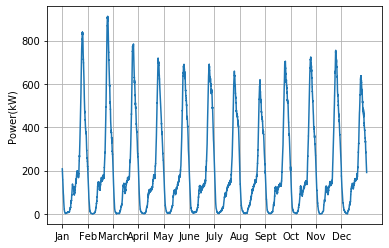

In [6]:
plt.plot(Monthly_average_power)
plt.ylabel('Power(kW)')
plt.grid()
plt.xticks(np.arange(0,17280,1440),('Jan','Feb','March','April','May','June','July','Aug','Sept','Oct','Nov','Dec'))

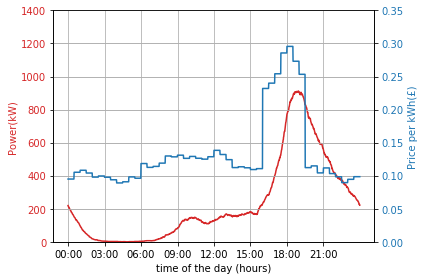

In [7]:
dfC = pd.read_csv("data/sspsbpniv.csv")
dfC.head()

MONTH= np.zeros(len(dfC))
for i in range(len(dfC)):
    MONTH[i] = datetime.datetime.strptime(dfC['Date'].iloc[i], '%d/%m/%Y').date().month

dfC['Month'] = MONTH
month = 2
dfc = dfC[dfC['Month'].eq(month)]

Cost = np.zeros(48)
for i in range(1,49,1):
    dfc1 = dfc[dfc['HalfHour'].eq(i)]
    Cost[i-1] = np.mean(dfc1['import(VAT)'].iloc[:])
cost = np.zeros(1440)

for i in range(len(Cost)):
    cost[(30*(i-1))+30:(30*i)+30] = Cost[i]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time of the day (hours)')
plt.xticks(np.arange(0,1440,180),('00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','24:00'))
ax1.set_ylabel('Power(kW)', color=color)
plt.ylim(0,1400)
ax1.plot(Feb, color=color)
plt.grid()
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Price per kWh(£)', color=color)  
plt.ylim(0,0.350)
ax2.plot(cost, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.grid()
plt.show()

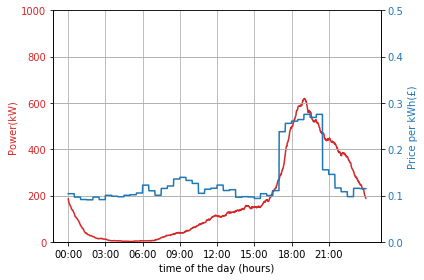

In [8]:
dfC = pd.read_csv("data/sspsbpniv.csv")
dfC.head()

MONTH= np.zeros(len(dfC))
for i in range(len(dfC)):
    MONTH[i] = datetime.datetime.strptime(dfC['Date'].iloc[i], '%d/%m/%Y').date().month

dfC['Month'] = MONTH
month = 8
dfc = dfC[dfC['Month'].eq(month)]

Cost = np.zeros(48)
for i in range(1,49,1):
    dfc1 = dfc[dfc['HalfHour'].eq(i)]
    Cost[i-1] = np.mean(dfc1['import(VAT)'].iloc[:])
cost = np.zeros(1440)

for i in range(len(Cost)):
    cost[(30*(i-1))+30:(30*i)+30] = Cost[i]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time of the day (hours)')
plt.xticks(np.arange(0,1440,180),('00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','24:00'))
ax1.set_ylabel('Power(kW)', color=color)
plt.ylim(0,1000)
ax1.plot(Aug, color=color)
plt.grid()
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Price per kWh(£)', color=color)  
plt.ylim(0,0.50)
ax2.plot(cost, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.grid()
plt.show()

In [9]:
DATAFRAME = pd.DataFrame(Monthly_average_power)

DATAFRAME.to_csv('NO SC DOMESTIC WEEKDAY.csv')

In [10]:
Total_cost = np.zeros(12)
for Z in range(12):
    dfC = pd.read_csv("data/sspsbpniv.csv")

    MONTH = np.zeros(len(dfC))
    for i in range(len(dfC)):
        MONTH[i] = datetime.datetime.strptime(dfC['Date'].iloc[i], '%d/%m/%Y').date().month

    dfC['Month'] = MONTH
    month = Z+1
    dfc = dfC[dfC['Month'].eq(month)]

    Cost = np.zeros(48)
    for i in range(1,49,1):
        dfc1 = dfc[dfc['HalfHour'].eq(i)]
        Cost[i-1] = np.mean(dfc1['import(VAT)'].iloc[:])
    cost = np.zeros(1440)

    for i in range(len(Cost)):
        cost[(30*(i-1))+30:(30*i)+30] = Cost[i]
        
    Energy = monthly_average[Z,:]/60
    
    Total_cost[Z] = np.sum(Energy*cost)

In [11]:
DF = pd.DataFrame(Total_cost)

DF.to_csv('NO SC DOMESTIC WEEKDAY COST.csv')

In [12]:
start = '2018-01-01'
end = '2018-02-01'
start_date = datetime.datetime.strptime(start, '%Y-%m-%d').date()
end_date = datetime.datetime.strptime(end, '%Y-%m-%d').date()
final = '2019-01-01'
final_date = datetime.datetime.strptime(final,'%Y-%m-%d').date()

while start_date < final_date:
    
    data = pd.read_excel("data/Greenflux Transactions.xlsx", sheet_name="Transaction Data")
    
    #Remove rows where the charge consumed is a NaN value or 0
    data = data[data['ConsumedkWh'].notna()]
    data.drop( data[data['ChargingDuration'] == 0 ].index , inplace=True)

    data['Plugged_In_Start_time'] = pd.to_datetime(data['AdjustedStartTime']).dt.time
    data['Plugged_In_End_time'] = pd.to_datetime(data['AdjustedStopTime']).dt.time

    data['Plugged_In_Start_date'] = pd.to_datetime(data['AdjustedStartTime']).dt.date
    data['Plugged_In_End_date'] = pd.to_datetime(data['AdjustedStopTime']).dt.date
    
    data = data[(data['Plugged_In_Start_date'] > start_date) & (data['Plugged_In_Start_date'] < end_date)]
   
    #Selecting which Trial to look at
    Trial = data[data.WeekdayOrWeekend.eq('Weekday')]

    unique_days = len(pd.unique(Trial['Plugged_In_Start_date']))
    unique_users = len(pd.unique(Trial['ParticipantID']))
    print(unique_users)
    start_date = start_date +relativedelta(months=+1)
    end_date = end_date + relativedelta(months=+1)

248
252
256
253
256
246
248
249
252
248
242
229
